In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 import 완료")


라이브러리 import 완료


In [15]:
data = pd.read_csv('/Users/aaron/Downloads/cancel_gig.csv')

df = pd.DataFrame(data)
print(f"데이터 형태: {df.shape}")
print("\n데이터 미리보기:")
df.head()

데이터 형태: (149, 8)

데이터 미리보기:


,gig_id,seller_rating,order_count,cancel_count,cancel_rate,cancel_rate_3m,cancel_rate_chnage_by_avg,cancel_rate_change_by_3m
0,620975,MASTER,182,13,7.10%,9.10%,614.30%,-21.40%
1,592778,MASTER,35,7,20.00%,10.40%,300.00%,92.70%
2,315263,MASTER,46,7,15.20%,13.00%,117.40%,17.20%
3,645489,MASTER,39,6,15.40%,9.20%,207.70%,66.80%
4,96346,NEW,53,6,11.30%,10.90%,126.40%,4.10%


In [16]:
# 데이터 전처리: 퍼센트 문자열을 숫자로 변환
def clean_percentage(value):
    """퍼센트 문자열을 숫자로 변환"""
    if isinstance(value, str):
        return float(value.replace('%', ''))/100.0
    return value

# 퍼센트 컬럼들을 숫자로 변환
percent_columns = ['cancel_rate', 'cancel_rate_3m', 'cancel_rate_chnage_by_avg', 'cancel_rate_change_by_3m']

for col in percent_columns:
    df[col] = df[col].apply(clean_percentage)

print("데이터 전처리 완료")
print("\n전처리된 데이터:")
df.head()


데이터 전처리 완료

전처리된 데이터:


,gig_id,seller_rating,order_count,cancel_count,cancel_rate,cancel_rate_3m,cancel_rate_chnage_by_avg,cancel_rate_change_by_3m
0,620975,MASTER,182,13,0.071,0.091,6.143,-0.214
1,592778,MASTER,35,7,0.200,0.104,3.000,0.927
2,315263,MASTER,46,7,0.152,0.130,1.174,0.172
3,645489,MASTER,39,6,0.154,0.092,2.077,0.668
4,96346,NEW,53,6,0.113,0.109,1.264,0.041


데이터 기본 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gig_id                     149 non-null    int64  
 1   seller_rating              149 non-null    object 
 2   order_count                149 non-null    int64  
 3   cancel_count               149 non-null    int64  
 4   cancel_rate                149 non-null    float64
 5   cancel_rate_3m             149 non-null    float64
 6   cancel_rate_chnage_by_avg  149 non-null    float64
 7   cancel_rate_change_by_3m   149 non-null    float64
dtypes: float64(4), int64(3), object(1)
memory usage: 9.4+ KB
None

기술 통계:
              gig_id  order_count  cancel_count  cancel_rate  cancel_rate_3m  \
count     149.000000   149.000000    149.000000   149.000000      149.000000   
mean   460303.442953    12.026846      2.604027     0.448161        0.125081   
std    180

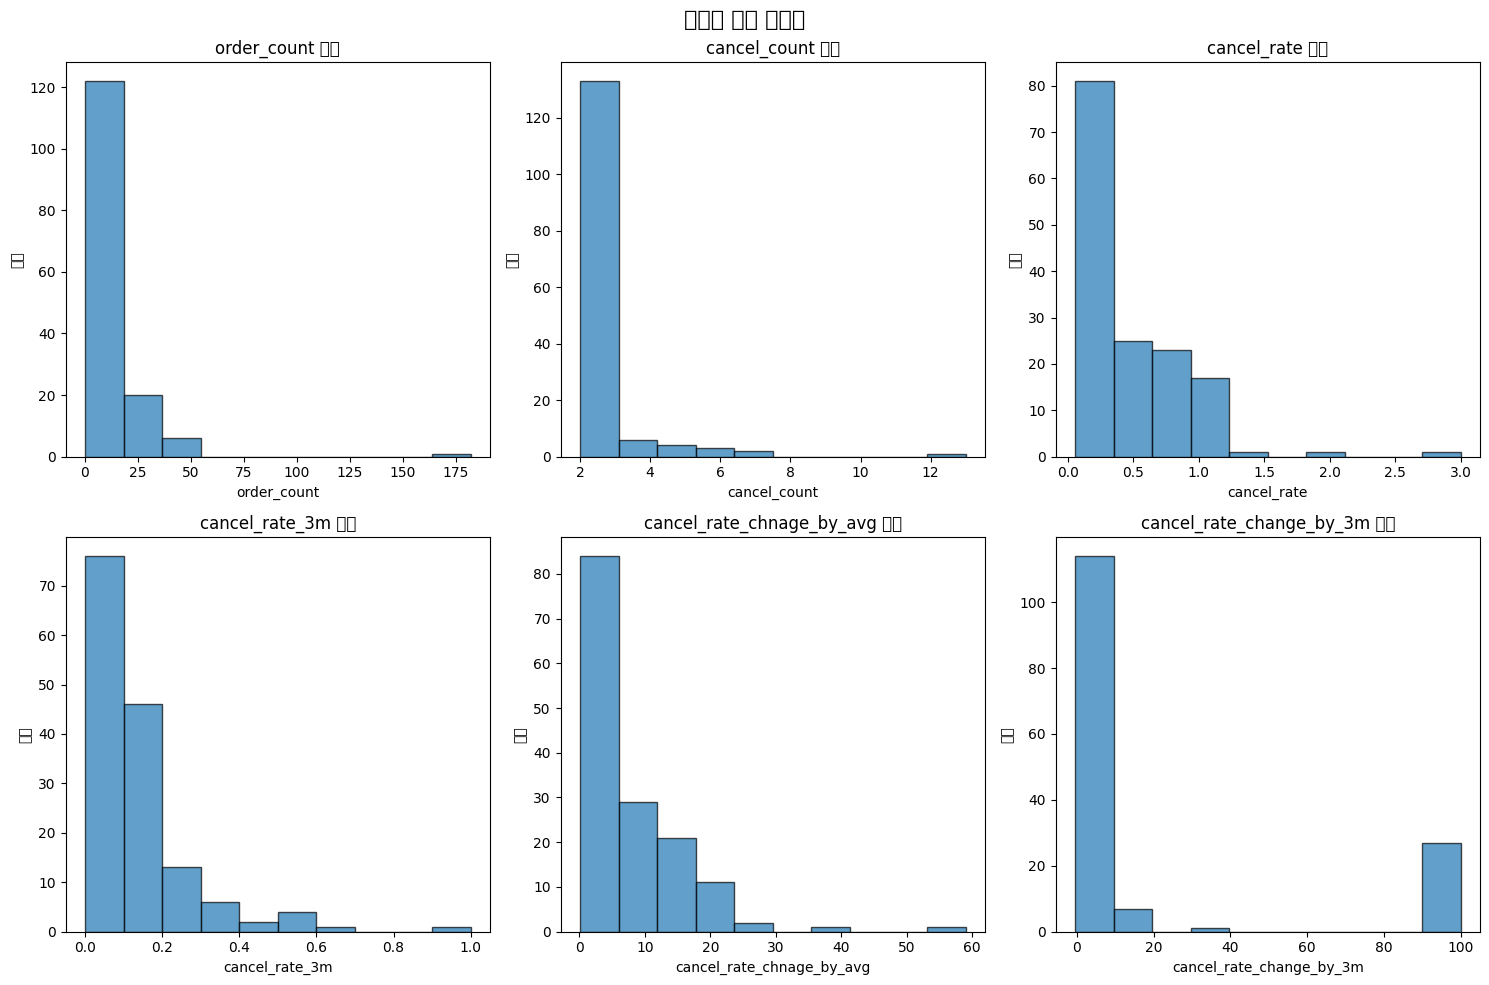

In [17]:
# 데이터 탐색 및 통계 정보
print("데이터 기본 정보:")
print(df.info())
print("\n기술 통계:")
print(df.describe())

# 데이터 분포 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('데이터 분포 시각화', fontsize=16)

# 수치형 컬럼들만 선택
numeric_columns = ['order_count', 'cancel_count', 'cancel_rate', 'cancel_rate_3m', 
                   'cancel_rate_chnage_by_avg', 'cancel_rate_change_by_3m']

for i, col in enumerate(numeric_columns):
    row = i // 3
    col_idx = i % 3
    axes[row, col_idx].hist(df[col], bins=10, alpha=0.7, edgecolor='black')
    axes[row, col_idx].set_title(f'{col} 분포')
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('빈도')

plt.tight_layout()
plt.show()


In [18]:
# 클러스터링을 위한 특성 선택 및 전처리
# gig_id는 식별자이므로 제외, seller_rating은 범주형이므로 제외
features = ['order_count', 'cancel_count', 'cancel_rate', 'cancel_rate_3m', 
           'cancel_rate_chnage_by_avg', 'cancel_rate_change_by_3m']

X = df[features].copy()

print("클러스터링에 사용할 특성:")
print(X.head())

# 데이터 표준화 (K-means는 거리 기반이므로 표준화가 중요)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n표준화된 데이터 형태: {X_scaled.shape}")
print("표준화된 데이터 샘플:")
print(X_scaled[:3])


클러스터링에 사용할 특성:
   order_count  cancel_count  cancel_rate  cancel_rate_3m  \
0          182            13        0.071           0.091   
1           35             7        0.200           0.104   
2           46             7        0.152           0.130   
3           39             6        0.154           0.092   
4           53             6        0.113           0.109   

   cancel_rate_chnage_by_avg  cancel_rate_change_by_3m  
0                      6.143                    -0.214  
1                      3.000                     0.927  
2                      1.174                     0.172  
3                      2.077                     0.668  
4                      1.264                     0.041  

표준화된 데이터 형태: (149, 6)
표준화된 데이터 샘플:
[[ 9.71289614  7.90594292 -0.97552302 -0.23453927 -0.15476437 -0.5539196 ]
 [ 1.3127712   3.34305527 -0.64186592 -0.14507441 -0.56536073 -0.52357677]
 [ 1.94135198  3.34305527 -0.7660174   0.03385531 -0.80390638 -0.54365463]]


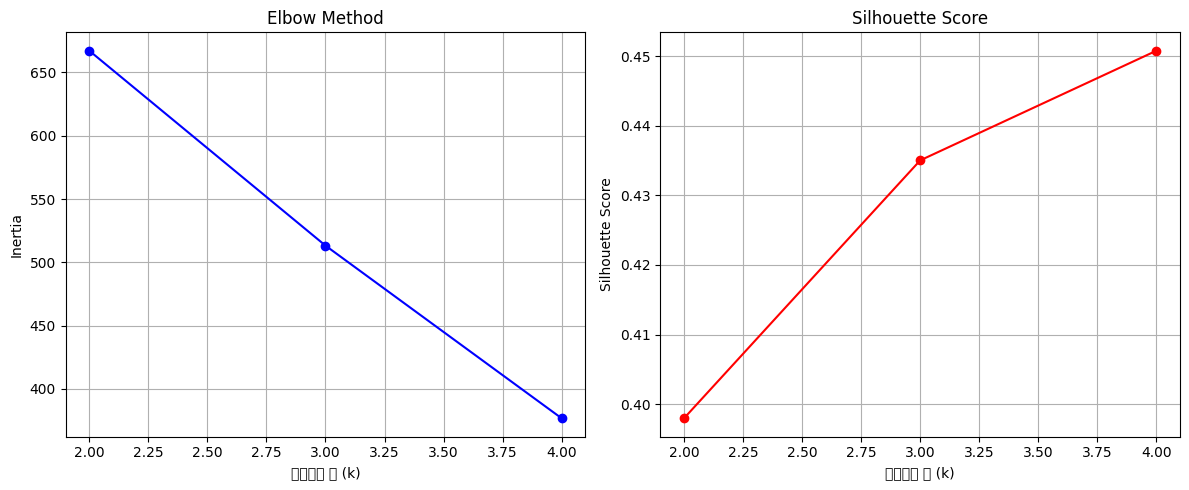

클러스터 수별 성능:
k=2: Inertia=667.12, Silhouette Score=0.398
k=3: Inertia=513.21, Silhouette Score=0.435
k=4: Inertia=376.79, Silhouette Score=0.451


In [19]:
# 최적 클러스터 수 찾기 (Elbow Method)
# 데이터가 적으므로 2-3개 클러스터로 제한
k_range = range(2, min(5, len(df)))  # 최대 4개까지
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Elbow Method 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('클러스터 수 (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax1.grid(True)

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('클러스터 수 (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score')
ax2.grid(True)

plt.tight_layout()
plt.show()

print("클러스터 수별 성능:")
for k, inertia, sil_score in zip(k_range, inertias, silhouette_scores):
    print(f"k={k}: Inertia={inertia:.2f}, Silhouette Score={sil_score:.3f}")


In [20]:
# 최적 클러스터 수로 K-means 수행
# Silhouette Score가 가장 높은 k 선택
best_k = k_range[np.argmax(silhouette_scores)]
print(f"최적 클러스터 수: {best_k}")

# K-means 클러스터링 수행
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# 결과를 데이터프레임에 추가
df['cluster'] = cluster_labels

print(f"\n클러스터링 완료!")
print(f"각 클러스터별 데이터 수:")
print(df['cluster'].value_counts().sort_index())

print(f"\n클러스터링 결과:")
print(df[['gig_id', 'cluster'] + features].sort_values('cluster'))


최적 클러스터 수: 4

클러스터링 완료!
각 클러스터별 데이터 수:
cluster
0    28
1    97
2     1
3    23
Name: count, dtype: int64

클러스터링 결과:
     gig_id  cluster  order_count  cancel_count  cancel_rate  cancel_rate_3m  \
10   692850        0            7             4        0.571           0.000   
18   686999        0           20             3        0.150           0.000   
17   546655        0            5             3        0.600           0.000   
20   170444        0            3             3        1.000           0.026   
19   391347        0           10             3        0.300           0.000   
..      ...      ...          ...           ...          ...             ...   
140  445918        3            4             2        0.500           0.552   
136  453489        3            2             2        1.000           1.000   
137  433389        3            3             2        0.667           0.674   
129  299005        3            4             2        0.500           0.364   
146 

In [21]:
# 클러스터별 특성 분석
print("클러스터별 평균값:")
cluster_means = df.groupby('cluster')[features].mean()
print(cluster_means.round(2))

print("\n클러스터별 특성 해석:")
for cluster_id in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cluster_id]
    print(f"\n클러스터 {cluster_id} ({len(cluster_data)}개 데이터):")
    print(f"  - 평균 주문 수: {cluster_data['order_count'].mean():.1f}")
    print(f"  - 평균 취소 수: {cluster_data['cancel_count'].mean():.1f}")
    print(f"  - 평균 취소율: {cluster_data['cancel_rate'].mean():.1f}%")
    print(f"  - 평균 3개월 취소율: {cluster_data['cancel_rate_3m'].mean():.1f}%")
    print(f"  - 평균 취소율 변화(평균 대비): {cluster_data['cancel_rate_chnage_by_avg'].mean():.1f}%")
    print(f"  - 평균 취소율 변화(3개월 대비): {cluster_data['cancel_rate_change_by_3m'].mean():.1f}%")


클러스터별 평균값:
         order_count  cancel_count  cancel_rate  cancel_rate_3m  \
cluster                                                           
0               4.46          2.25         0.69            0.00   
1              14.45          2.61         0.27            0.10   
2             182.00         13.00         0.07            0.09   
3               3.61          2.57         0.91            0.37   

         cancel_rate_chnage_by_avg  cancel_rate_change_by_3m  
cluster                                                       
0                            10.63                     97.75  
1                             4.32                      2.79  
2                             6.14                     -0.21  
3                            16.04                      2.79  

클러스터별 특성 해석:

클러스터 0 (28개 데이터):
  - 평균 주문 수: 4.5
  - 평균 취소 수: 2.2
  - 평균 취소율: 0.7%
  - 평균 3개월 취소율: 0.0%
  - 평균 취소율 변화(평균 대비): 10.6%
  - 평균 취소율 변화(3개월 대비): 97.8%

클러스터 1 (97개 데이터):
  - 평균 주문 수: 14.5
  - 평균 취소

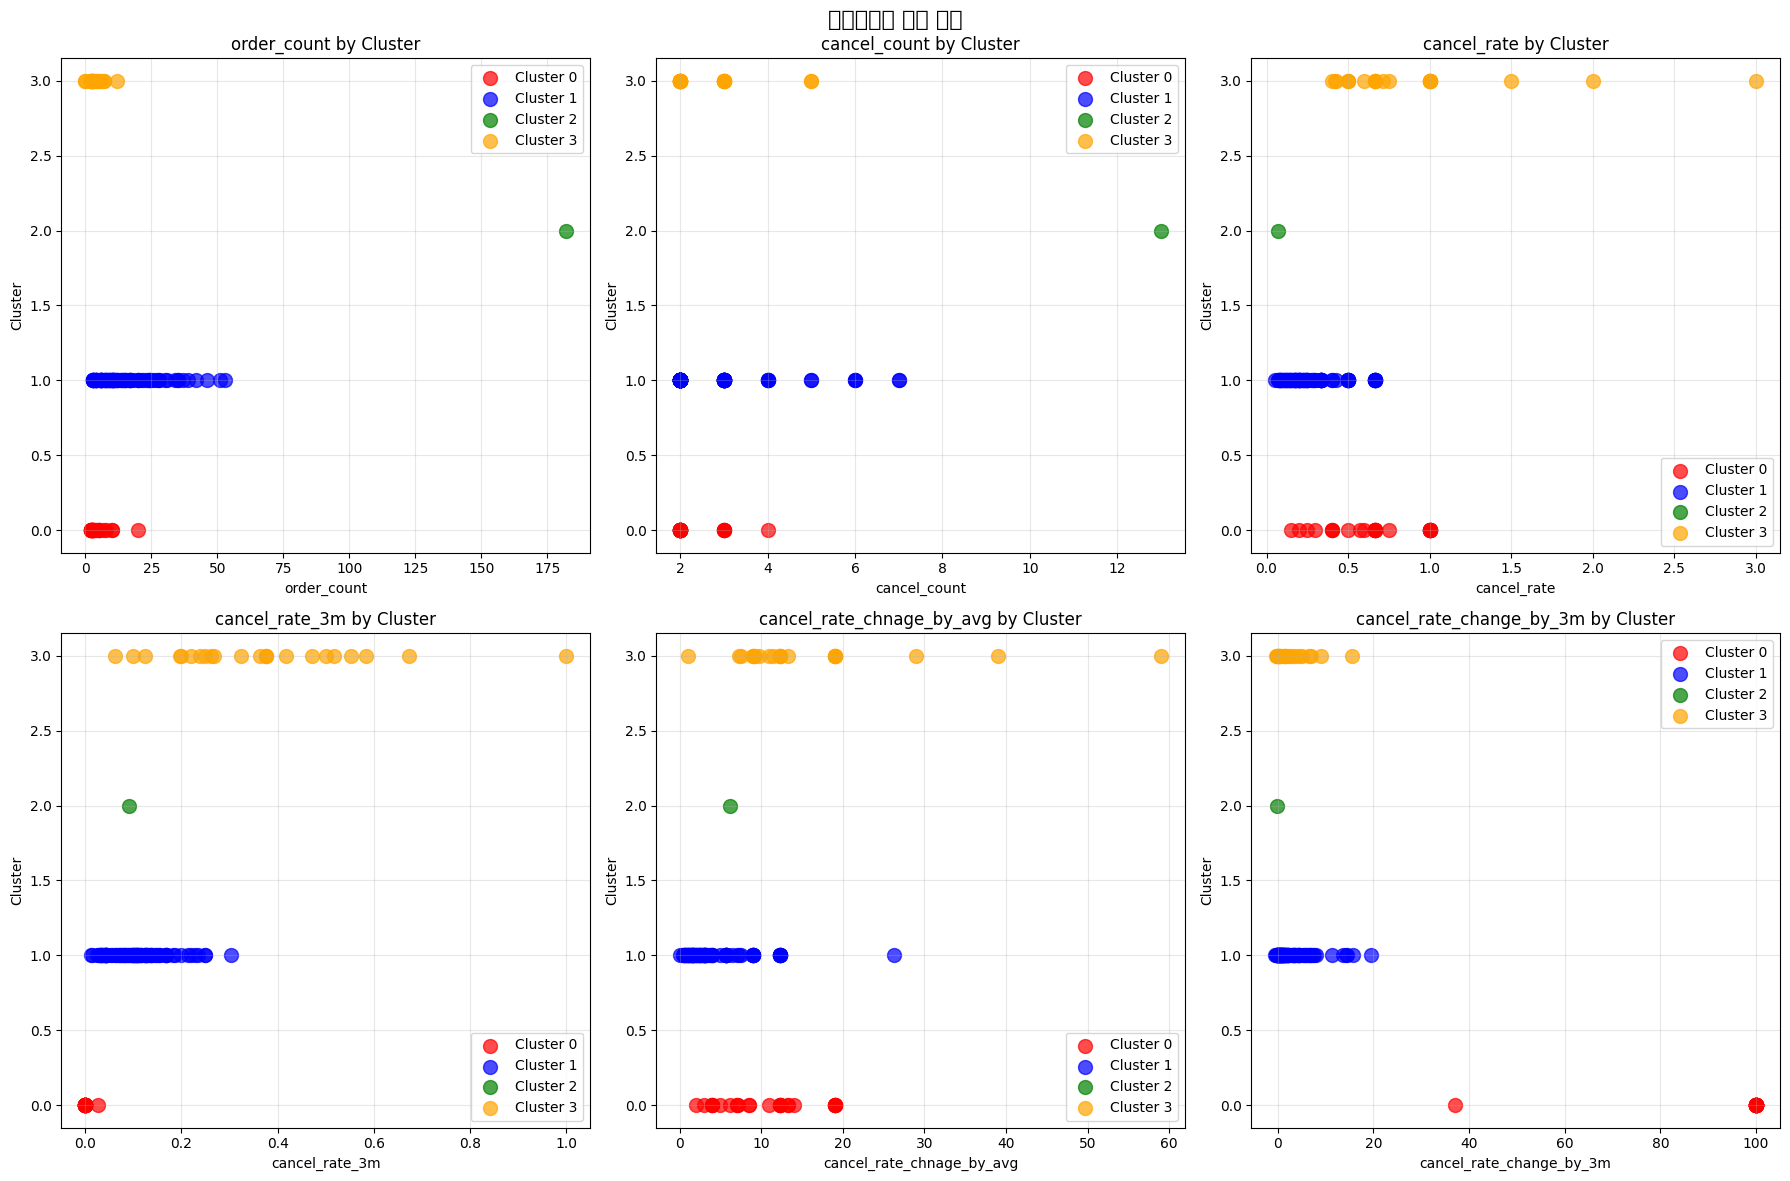

In [22]:
# 클러스터링 결과 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('클러스터별 특성 분포', fontsize=16)

colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, feature in enumerate(features):
    row = i // 3
    col = i % 3
    
    for cluster_id in sorted(df['cluster'].unique()):
        cluster_data = df[df['cluster'] == cluster_id]
        axes[row, col].scatter(cluster_data[feature], 
                              [cluster_id] * len(cluster_data), 
                              c=colors[cluster_id], 
                              label=f'Cluster {cluster_id}',
                              alpha=0.7, s=100)
    
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Cluster')
    axes[row, col].set_title(f'{feature} by Cluster')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


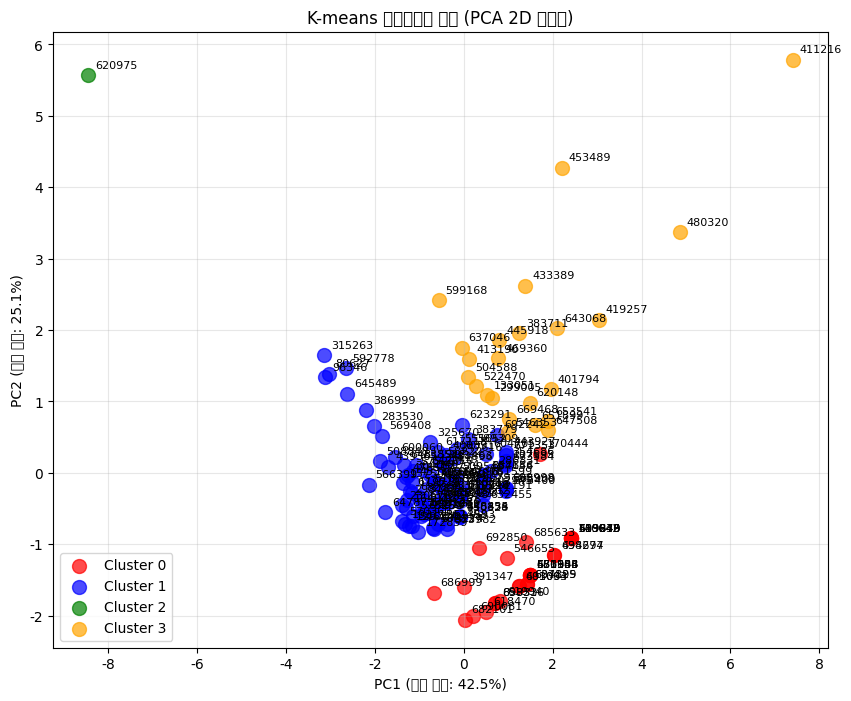

PCA 설명 분산 비율: [0.42532932 0.25134148]
총 설명 분산: 67.7%


In [23]:
# PCA를 사용한 2D 시각화 (6차원 데이터를 2차원으로 축소)
from sklearn.decomposition import PCA

# PCA 적용
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# PCA 결과 시각화
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'orange', 'purple']

for cluster_id in sorted(df['cluster'].unique()):
    cluster_mask = df['cluster'] == cluster_id
    plt.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1], 
               c=colors[cluster_id], label=f'Cluster {cluster_id}', 
               alpha=0.7, s=100)

plt.xlabel(f'PC1 (설명 분산: {pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 (설명 분산: {pca.explained_variance_ratio_[1]:.1%})')
plt.title('K-means 클러스터링 결과 (PCA 2D 시각화)')
plt.legend()
plt.grid(True, alpha=0.3)

# 각 점에 gig_id 표시
for i, gig_id in enumerate(df['gig_id']):
    plt.annotate(str(gig_id), (X_pca[i, 0], X_pca[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.show()

print(f"PCA 설명 분산 비율: {pca.explained_variance_ratio_}")
print(f"총 설명 분산: {pca.explained_variance_ratio_.sum():.1%}")


In [24]:
# 최종 결과 요약
print("="*60)
print("K-means 클러스터링 결과 요약")
print("="*60)

print(f"데이터 수: {len(df)}개")
print(f"사용된 특성: {', '.join(features)}")
print(f"최적 클러스터 수: {best_k}개")
print(f"Silhouette Score: {silhouette_score(X_scaled, cluster_labels):.3f}")

print(f"\n클러스터별 상세 정보:")
for cluster_id in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cluster_id]
    print(f"\n[클러스터 {cluster_id}] - {len(cluster_data)}개 데이터")
    print(f"  Gig IDs: {', '.join(map(str, cluster_data['gig_id'].tolist()))}")
    
    # 클러스터 특성 요약
    if cluster_data['order_count'].mean() > df['order_count'].mean():
        order_status = "높음"
    else:
        order_status = "낮음"
    
    if cluster_data['cancel_rate'].mean() > df['cancel_rate'].mean():
        cancel_status = "높음"
    else:
        cancel_status = "낮음"
    
    print(f"  특성: 주문량 {order_status}, 취소율 {cancel_status}")

print(f"\n클러스터링이 완료되었습니다!")
print(f"실제 CSV 파일을 사용하려면 첫 번째 셀의 데이터 생성 부분을")
print(f"df = pd.read_csv('your_file.csv')로 변경하세요.")


K-means 클러스터링 결과 요약
데이터 수: 149개
사용된 특성: order_count, cancel_count, cancel_rate, cancel_rate_3m, cancel_rate_chnage_by_avg, cancel_rate_change_by_3m
최적 클러스터 수: 4개
Silhouette Score: 0.451

클러스터별 상세 정보:

[클러스터 0] - 28개 데이터
  Gig IDs: 692850, 685633, 546655, 686999, 391347, 170444, 551946, 658316, 89953, 690081, 681338, 638274, 493064, 533236, 140642, 689875, 607899, 560104, 634125, 451683, 682101, 499649, 601093, 515949, 494697, 676953, 619940, 618470
  특성: 주문량 낮음, 취소율 높음

[클러스터 1] - 97개 데이터
  Gig IDs: 592778, 315263, 645489, 96346, 80627, 569408, 386999, 119718, 617118, 648159, 508848, 283530, 65154, 692242, 407929, 318232, 82894, 389309, 409387, 566399, 346774, 400891, 58222, 623291, 453102, 642010, 478507, 304051, 575260, 538528, 325670, 439365, 600060, 575400, 365909, 609998, 632455, 373982, 252191, 450328, 448435, 558854, 673584, 202945, 107595, 513593, 354686, 671353, 286831, 674274, 651599, 443927, 172859, 337656, 664144, 506127, 562498, 635602, 139518, 610246, 490355, 546340, 1297